<a href="https://colab.research.google.com/github/avinashmane/colab/blob/master/strava_likers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Code/Parameters
* Setup
    * needs
        * auth
        * gsheet auth
        * cfg_strava
* updates sheets
* Todo
    * low: error: location not found 

## Config

In [1]:
repo='https://github.com/avinashmane/colab.git'
import os,sys
if os.name=='nt':
    LIB= r'c:\m\lib'
    LOG= r'c:\m\social-media-automation'
    AUTH= r'c:\i\auth'
    sys.path.append("./lib")
else:
    if not os.path.exists('drive'):
        from google.colab import drive
        drive.mount('/content/drive')
    LIB='/content/drive/MyDrive/m/lib'
    LOG='/content/drive/MyDrive/m/lib'
    AUTH='/content/drive/MyDrive/m/auth'
    if not os.path.exists('m'):
      !ln -sd '/content/drive/MyDrive/m/' m
    if not os.path.exists('repo'):
      !git clone $repo repo
    sys.path.append('repo')
    sys.path.append("repo/lib")
sys.path.append(LIB)


In [2]:
import yaml
cfg=yaml.load(u"""
repo:
    https://github.com/avinashmane/colab.git
packages: 
    chromium-chromedriver
modules:
    nerodia
    pygsheets
env:
    nt:
        LIB: c:/m/lib
        LOG: c:/m/social-media-automation
        AUTH: c:/i/auth
    posix:
        LIB: /content/drive/MyDrive/m/lib
        LOG: /content/drive/MyDrive/m/lib
        AUTH: /content/drive/MyDrive/m/auth
sheets:
    stravasync:
        url: https://docs.google.com/spreadsheets/d/1Q8SA641P0aytWzPGmeHG_xuxll3Wq6phsxjb91RjgWY/edit#gid=0
        tab: Members
        range: A10:O
    StravaPromoLog:
        url: https://docs.google.com/spreadsheets/d/1Q8SA641P0aytWzPGmeHG_xuxll3Wq6phsxjb91RjgWY/edit#gid=0
        tab: StravaPromoLog
        
""",Loader=yaml.Loader)
for x in cfg['env'][os.name]: 
    os.environ[x]=eval(x)

import importlib
import utils
importlib.reload(utils)
utils.setup_env(cfg['packages'],cfg['modules'])

'Environment setup'

## Code

In [124]:
import yaml
from datetime import datetime
import os
from nerodia.browser import Browser
import nerodia
import re
import logging
from IPython.display import Image

import utils

import socialmediasite 
importlib.reload(socialmediasite)
Strava=socialmediasite.Strava
SocialMediaSite=socialmediasite.SocialMediaSite


In [5]:
"reach gsheet"

import gsheets
Gsheet=gsheets.Gsheet


In [125]:
df_mc=Gsheet(cfg['sheets']['stravasync']['url']).getSheetDf(cfg['sheets']['stravasync']['tab'],start='A10')

# ssl=Gsheet('stravasync')
# df_mc

# Process
## Create headless

In [11]:
" Test Selenium headless"
if True:
    if os.name=='nt':
        b=Browser('chrome',)
    else:
        
        # import sys
        # sys.path.insert(0,f'{DIR}/geckodriver')
        from selenium import webdriver

        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--disable-dev-shm-usage')
        # b =webdriver.Chrome('chromedriver',options=chrome_options)
        b=Browser('chrome',options=chrome_options,)
    
    utils.setLogger(f"{LOG}/strava-automation.log")
    

2022-08-15 22:45:45:INFO:Logger file: c:\m\social-media-automation/strava-automation.log


In [126]:
# %debug
# if os.name=='nt':
strava=Strava(b,authFile=f'{AUTH}/auth.yaml',cfgFile=f"{LIB}/cfg_strava.yaml")
strava.logGSheet = Gsheet(cfg['sheets']['stravasync']['url']).getSheetByTitle('StravaPromoLog')
strava.StravaMembers=df_mc.query('strava=="strava"').id.values

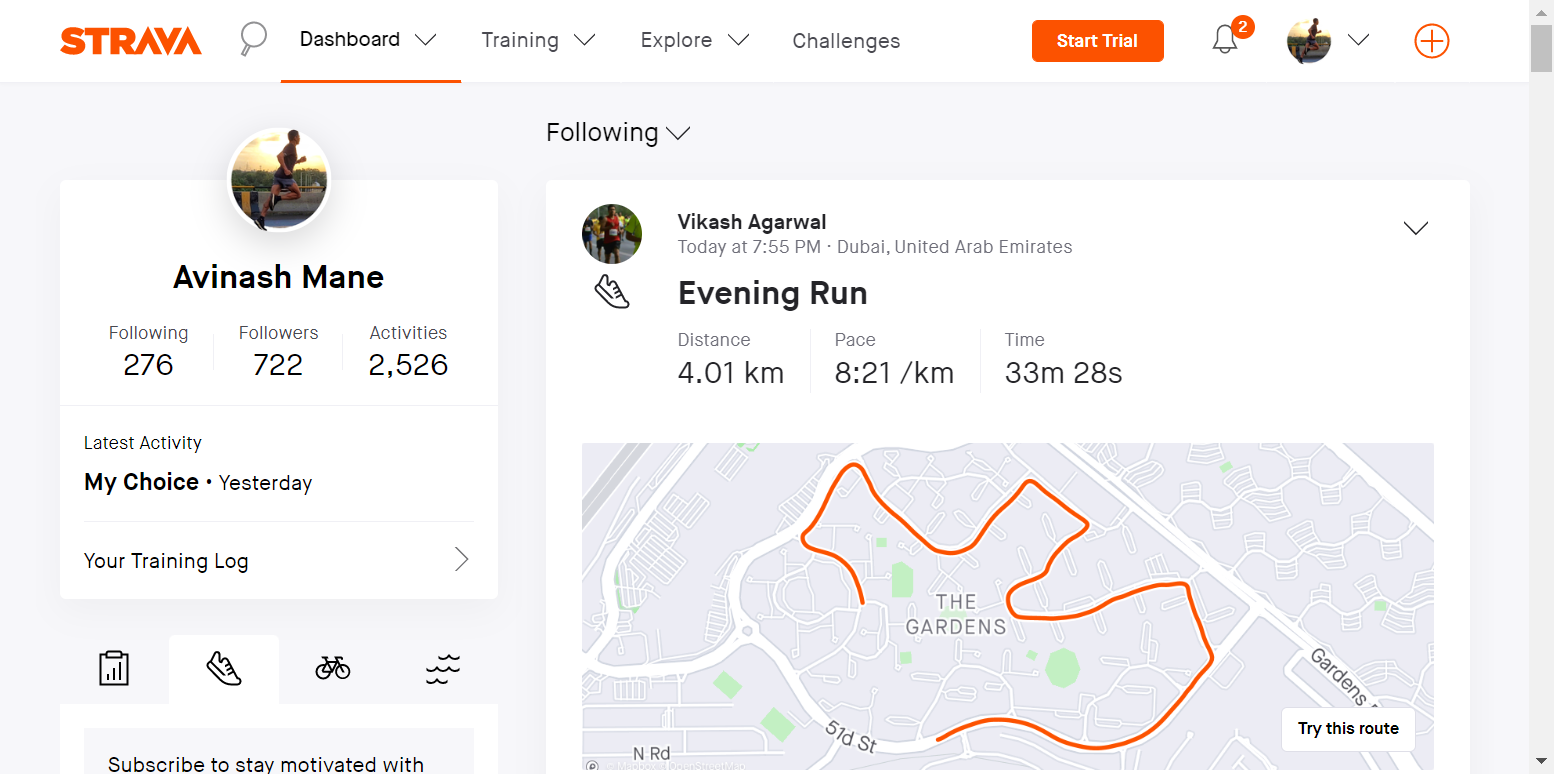

In [13]:
strava.login("avinash")

Image(b.screenshot.png())

## A. Give likes in feed

In [121]:
# b.goto('https://www.strava.com/clubs/196654/recent_activity')

strava.scrolldown(9)

In [122]:
logging.info(f"Total number of cards on {strava.browser.title}: {len(b.divs(class_name=re.compile('^EntryHeader')))}")

2022-08-16 00:03:51:INFO:Total number of cards on Dashboard | Strava: 167


In [127]:
strava.giveKudos()

2022-08-16 00:07:12:INFO:giveKudos: 0,49879981,https://www.strava.com/athletes/49879981 https://www.strava.com/activities/7638014370 Night Walk
2022-08-16 00:07:15:INFO:giveKudos: 1,44486618,https://www.strava.com/athletes/44486618 https://www.strava.com/activities/7637665476 Evening Walk
2022-08-16 00:07:19:INFO:giveKudos: 2,43792677,https://www.strava.com/athletes/43792677 https://www.strava.com/activities/7639807156 Morning Run
2022-08-16 00:07:22:INFO:giveKudos: 3,nonMember,https://www.strava.com/athletes/7707597 https://www.strava.com/activities/7639852262 Body weight strength Training
2022-08-16 00:07:26:INFO:giveKudos: 4,51017407,https://www.strava.com/athletes/51017407 https://www.strava.com/activities/7638382076 Night Walk
2022-08-16 00:07:30:INFO:giveKudos: 5,22528841,https://www.strava.com/athletes/22528841 https://www.strava.com/activities/7639876117 Morning Yoga
2022-08-16 00:07:34:INFO:giveKudos: 6,24454841,https://www.strava.com/athletes/24454841 https://www.strava.com/a

## Give likes on Club

In [128]:
# b.goto('https://www.strava.com/clubs/196654/recent_activity')
strava.login("strava_pcmcrunners")
logging.info(f"Total number of cards on {strava.browser.title}: {len(b.divs(class_name=re.compile('^Card')))}")
strava.giveKudos()

2022-08-16 00:12:34:INFO:Total number of cards on Dashboard | Strava: 19


In [129]:
for club in strava.cfg['pcmcrunners']['clubs']:
  strava.goto(f"{club}/recent_activity")
  logging.info(f"Total number of cards on {club} '{strava.browser.title}': {len(b.divs(class_name=re.compile('^Card')))}")
  strava.giveKudos()

2022-08-16 00:12:45:INFO:Total number of cards on https://www.strava.com/clubs/pcmcrunners 'Pimpri-Chinchwad, Maharashtra, India Club | PCMCRunners on Strava': 20
2022-08-16 00:12:47:INFO:giveKudos: 0,nonMember,https://www.strava.com/athletes/20651980 https://www.strava.com/activities/7643563350 Night Run
2022-08-16 00:12:50:INFO:giveKudos: 1,nonMember,https://www.strava.com/athletes/65702938 https://www.strava.com/activities/7643532781 For Sunshine ☀️ Stephanie ❤️❤️❤️
2022-08-16 00:12:53:INFO:giveKudos: 2,19815602,https://www.strava.com/athletes/19815602 https://www.strava.com/activities/7643405867 Night Run
2022-08-16 00:12:56:INFO:giveKudos: 3,nonMember,https://www.strava.com/athletes/19183337 https://www.strava.com/activities/7643264108 Evening Run
2022-08-16 00:13:03:INFO:Total number of cards on https://www.strava.com/clubs/prettycoolmileagechallenge 'India Club | Milage Challenge : 2022 in 2022 on Strava': 20
2022-08-16 00:13:12:INFO:Total number of cards on https://www.strava.c

# Test like

In [19]:
import unittest
logging.info(f"Total number of cards on {strava.browser.title}: {len(b.divs(class_name=re.compile('^Card')))}")
logging.info(f"Total number of cards on {strava.browser.title}: {len(b.divs(class_name=re.compile('^EntryHeader')))}")

2022-08-15 22:46:49:INFO:Total number of cards on Atlanta, Georgia Club | Mileage League: 2022 in 2022 on Strava: 20
2022-08-15 22:46:49:INFO:Total number of cards on Atlanta, Georgia Club | Mileage League: 2022 in 2022 on Strava: 20


In [25]:
for c_ in b.buttons(data_testid="kudos_button"):#text=re.compile('.*udos')): #'^EntryHeader')
    # print(dir(c_))
    actEl=c_.parent(class_name=re.compile('^EntryFooter')
                       ).parent()#.siblings(class_name=re.compile('^EntryHeader'))[0]
    # print(">",actEl.exists,actEl.tag_name,actEl.class_name,actEl.text[:9],)
    try:
        ath,athUrl=utils.getAttrsIfExists( actEl.link(data_testid="owners-name"),
                               ['text','href'])#,)
        loc=utils.getAttrsIfExists( actEl.div(data_testid="location"))
        act,actUrl=utils.getAttrsIfExists( actEl.link(data_testid="activity_name"),
                               ['text','href'])#,)
        kudoCount=utils.getAttrsIfExists( actEl.button(data_testid="kudos_count"))
        print(ath,athUrl,act,actUrl,kudoCount,loc)
    # ss.append_table([[pd.Timestamp.now().isoformat(),"INFO","giveKudos",id,athId,name,actId,loc,]])    
    # logging.info(f"giveKudos: {i},{id},{athId} {actId} {hdr.text.split(',')[:1]}")
        # print(">>",len(c_.elements()),
        #       c_.text.replace("\n","/")[:80],
        #      )
        # utils.dumpChildren(actEl,attr=['tag_name','class_name','text','data_testid','id'])
    except TimeoutError:
        print('timeout')
    except Exception as e:
        print (f"something else {e!r}")

Vikash Agarwal https://www.strava.com/athletes/9233466 Evening Run https://www.strava.com/activities/7643109551 1 kudos  · Dubai, United Arab Emirates
Michelle Walker https://www.strava.com/athletes/6429484 Forgot My Water Bottles https://www.strava.com/activities/7642558930 19 kudos  · Warrick County, USA
Rick Simonson https://www.strava.com/athletes/3171614 Morning Run https://www.strava.com/activities/7642711821 8 kudos  · Ridgway, USA
Eric Ashe https://www.strava.com/athletes/8169908 Forgive us our trespasses https://www.strava.com/activities/7642774361 29 kudos  · Natick, USA
Swaminathan Srinivasan https://www.strava.com/athletes/16353981 Morning Walk https://www.strava.com/activities/7642481616 6 kudos  · Haveli, Maharashtra
Paul O'Neil https://www.strava.com/athletes/8476113 Upper Body Strength https://www.strava.com/activities/7642818271 7 kudos 
Vivek Chaudhari 🇮🇳 https://www.strava.com/athletes/24454841 Night Walk https://www.strava.com/activities/7642750613 12 kudos  · Havel

In [21]:
bs=b.elements(tag_name='a',)
len(bs)

299

In [31]:
"""
This is the "example" module.

The example module supplies one function, factorial().  For example,

>>> factorial(5)
120
"""

def factorial(n):
    """Return the factorial of n, an exact integer >= 0.

    >>> [factorial(n) for n in range(6)]
    [1, 1, 2, 6, 24, 120]
    >>> factorial(30)
    265252859812191058636308480000000
    >>> factorial(-1)
    Traceback (most recent call last):
        ...
    ValueError: n must be >= 0

    Factorials of floats are OK, but the float must be an exact integer:
    >>> factorial(30.1)
    Traceback (most recent call last):
        ...
    ValueError: n must be exact integer
    >>> factorial(30.0)
    265252859812191058636308480000000

    It must also not be ridiculously large:
    >>> factorial(1e100)
    Traceback (most recent call last):
        ...
    OverflowError: n too large
    """

    import math
    if not n >= 0:
        raise ValueError("n must be >= 0")
    if math.floor(n) != n:
        raise ValueError("n must be exact integer")
    if n+1 == n:  # catch a value like 1e300
        raise OverflowError("n too large")
    result = 1
    factor = 2
    while factor <= n:
        result *= factor
        factor += 1
    return result


import doctest
doctest.testmod(verbose=False)

TestResults(failed=0, attempted=7)

In [63]:
import unittest
importlib.reload(unittest)

class Avinash(unittest.TestCase):
    def setUp(self):
        print('setup')
    def tearDown(self):
        print('teardown')
        
    def test(self):
        # date = datetime.date(2020, 1, 1)
        self.assertEqual(2+3, 5)
        
    def test2(self):
        # date = datetime.date(2019, 12, 31)
        self.assertEqual(6/2, 3)
        
res = unittest.main(argv=[''], verbosity=0, exit=False)
# if we want our notebook to stop processing due to failures, we need a cell itself to fail
assert len(res.result.failures) == 0


setup
teardown
setup
teardown


----------------------------------------------------------------------
Ran 2 tests in 0.001s

OK


In [70]:
importlib.reload(utils)
bs=b.buttons(data_testid="comment_button")
len(bs)

11

In [111]:
# utils.dumpParents(bs[0])


for bs_ in bs:#bs0=bs[1]#.parent(class_name='EntryHeader--entry-header--lXRRn')
    postComment(bs_)
# utils.dumpTag(bs0)

    
# utils.dumpTag(bs0)
# utils.dumpChildren(bs0.parent(data_testid='kudos_comments_container'),"tag_name|class_name|text|title|data_testid".split('|'))

In [104]:
ta.value='Nice!'

In [ ]:
dir(bs0)

In [ ]:
bs0=bs[0].parent(class_name='EntryHeader--entry-header--lXRRn')
for i in range(5):
    bs0=bs0.parent()
    utils.dumpTag(bs0)

In [ ]:
dir(bs[0].el)

In [ ]:
importlib.reload(utils)
len(bs)
utils.dumpChildren(bs0,attr=['tag_name','class_name','text','data_testid'])

In [ ]:
utils.dumpParents(bs[0])

# Test post

In [ ]:
## Comment on PCMC club
strava.goto("https://www.strava.com/clubs/196654/recent_activity")

In [ ]:
card=strava.getParent(x1[0],'div','^Card')

In [ ]:
card.text
[x.link().text for x in [card.div(class_name=re.compile("^MediaBody--media-body--"))]]

In [ ]:
KudosButtons=strava.browser.buttons(title=strava.giveKudosPattern)
for i,x in enumerate(KudosButtons):
  try:
    card=strava.getParent(x,'div','^Card')
    athId,ath=SocialMediaSite.getLinkByClassPatt(card,"^Avatar--")
    actId,_=SocialMediaSite.getLinkByClassPatt(card,"^ActivityEntryBody--")
    for x in card.divs(class_name=re.compile("^MediaBody--media-body--")):
        name=x.link().text
        if x.exists:
            locEl=x.div(class_name=re.compile('^LocationAndTime--location--',)).wait_until(timeout=0.1, method=lambda _: True)
            loc=locEl
    # text=card.text.split(',')[:1]
    print(name,loc)
    # x.click() 
    try:
        x = int(re.findall(".*\/([0-9]*)",athId)[0])
        if x not in StravaMembers:
            x='nonMember'
    except:
        x='not valid'

    # self.browser.execute_script("arguments[0].click();", x)
    ss.append_table([[pd.Timestamp.now().isoformat(),"INFO","Comments",x,athId,name,actId,loc,]])    
    logging.info(f"giveKudos: {i},{x} {athId} {actId} {name}")
  except Exception as e: 
    logging.warning(f"giveKudos: {i} error clicking {e!r}")


In [ ]:
b.link(href="#container-nav").click()

In [ ]:
b.button(title="Expand profile menu").hover()

In [ ]:
[(x.text,x.class_name,x.tag_name) for x in b.button(title="Expand profile menu").span().span()]

In [ ]:
# b.execute_script("window.scrollTo(0,0)")
# Image(b.screenshot.png())
re.findall(".*\/([0-9]*)","https://www.strava.com/athletes/27331750")[0]

In [ ]:
"get all attributes"
# for x in dir(b):
#   print(x,type(getattr(b,x)),)

# New section
